# Imports

In [1]:
import pickle
import json
from __future__ import division
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from numpy.random import randint
from numpy.random import rand
import multiprocessing as mp
import random
import math
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.layers import Input,Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, BatchNormalization,LSTM,Bidirectional
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,UpSampling1D, Conv1DTranspose,GaussianNoise 
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback
from keras.regularizers import l2 , l1, l1_l2
import tensorflow.keras.backend as kb
print('keras version ', keras.__version__)

from keras.utils.vis_utils import plot_model

keras version  2.9.0


# Functions

In [2]:
def df_to_fasta(df, path):
    lines = []
    df.apply(lambda row: lines.append(f">{row['tag']}\n{row['data']}\n"),axis=1)
    with open(path,'w') as file:
        file.write(''.join(lines))

In [3]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    tags = []
    data = []
    for l in lines:
        if(l[0]=='>'):
            tags.append(l)        
            data.append(s)
            s = ''
        else:
            s += l    
    data.append(s)
    df = pd.DataFrame(
            {
                'tag': tags,
                'data': data[1:]
            })
    df['tag'] = df['tag'].apply(lambda x: x[1:])    
    return df

In [4]:
class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [5]:
def confusion_matrix(validations, predictions, LABELS):            
    freq = metrics.confusion_matrix(validations, predictions)        
    sensitivity =  (np.divide(freq.transpose(),
                             np.sum(freq, axis=1)).transpose() * 100).round(2)    
    annotation = []
    for i in range(freq.shape[0]):
        row = []
        for j in range(freq.shape[1]):
            row.append(f'{freq[i][j]}\n {sensitivity[i][j]}%')            
        annotation.append(row)
    annotation = np.array(annotation)
    sns.heatmap(sensitivity, cmap="YlOrBr",
                vmin=0, vmax=100,
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=annotation,
               fmt=':<')    
    plt.title("Confusion Matrix")
    plt.ylabel("Actually Label")
    plt.xlabel("Predicted Label")
    plt.show()            

def report(pred, df, ref):
    number_of_hit = len(df['hit seq'].unique())
    print(f'number of unique hit: {number_of_hit}')
    total = len(df[df['hit seq'].isin(ref['data'])]['hit seq'].unique()) 
    print(f'total mir: {total}')    
    selected = df[pd.Series(pred).apply(lambda x: True if x==1 else False)]
    found_seq = selected[selected['hit seq'].isin(ref['data'])]['hit seq'].unique()
    found = len(found_seq)
    print(f'found mir : {found}')
    print(f'fount to all : {round(found / total * 100, 2)}%')
    fp = len(selected[~selected['hit seq'].isin(ref['data'])]['hit seq'].unique())
    print(f'fp: {fp}')

# Load all plant dataset

In [16]:
all_plant = [
    ["A.thaliana", 288],
    ["C.sinensis", 182],
    ["G.max", 404],
    ["G.raimondii", 234],
    ["M.truncatula", 406],
    ["O.sativa", 482],
    ["S.bicolor", 174], 
    ["T.aestivum", 77],
    ["Z.mays", 199]         
]

In [31]:
result = {}
for item in all_plant:    
    plant, number = item
    y_true = [*[1]*number, *[0]*number]    
    y_true = np.array(y_true)
    pos_pred = fasta_to_df(f"{plant}/{plant}_positive.txt.fa")
    tp = pos_pred.shape[0] 
    y_pred_pos = [*[1]*tp, *[0]*(number-tp)]        
    neg_pred = fasta_to_df(f"{plant}/{plant}_negative.txt.fa")        
    fp = neg_pred.shape[0]
    y_pred_neg = [*[1]*fp, *[0]*(number-fp)]        
    y_pred = np.array([*y_pred_pos, *y_pred_neg])
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    result[plant] = {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "precision": metrics.precision_score(y_true, y_pred),
        "recall": metrics.recall_score(y_true, y_pred),
        "specificity": tn / (tn+fp),            
        "f1": metrics.f1_score(y_true, y_pred),
        "mcc": metrics.matthews_corrcoef(y_true, y_pred)        
    }    

In [32]:
result

{'A.thaliana': {'accuracy': 0.8229166666666666,
  'precision': 0.9428571428571428,
  'recall': 0.6875,
  'specificity': 0.9583333333333334,
  'f1': 0.7951807228915663,
  'mcc': 0.6709076657921977},
 'C.sinensis': {'accuracy': 0.8159340659340659,
  'precision': 0.9831932773109243,
  'recall': 0.6428571428571429,
  'specificity': 0.989010989010989,
  'f1': 0.7774086378737541,
  'mcc': 0.67350576496029},
 'G.max': {'accuracy': 0.7735148514851485,
  'precision': 0.827893175074184,
  'recall': 0.6905940594059405,
  'specificity': 0.8564356435643564,
  'f1': 0.7530364372469636,
  'mcc': 0.5547111169951654},
 'G.raimondii': {'accuracy': 0.46153846153846156,
  'precision': 0.46218487394957986,
  'recall': 0.4700854700854701,
  'specificity': 0.452991452991453,
  'f1': 0.4661016949152542,
  'mcc': -0.07693431805669285},
 'M.truncatula': {'accuracy': 0.7807881773399015,
  'precision': 0.8584905660377359,
  'recall': 0.6724137931034483,
  'specificity': 0.8891625615763546,
  'f1': 0.7541436464088

# Evaluation

In [33]:
def evaluation(plant):
    y_true = np.argmax(data[plant]['target'], axis=1)
    y_pred =  np.argmax(model.predict(data[plant]['feature']), axis=1)
    confusion_matrix(y_true,y_pred,["No","YES"])
    print(classification_report(y_true, y_pred))

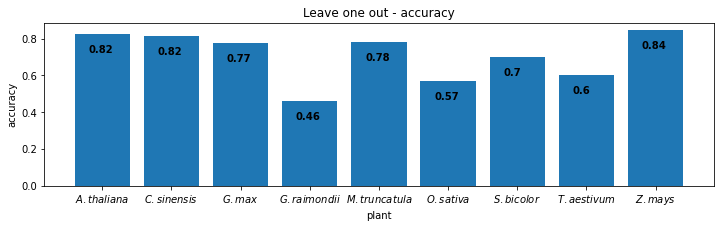

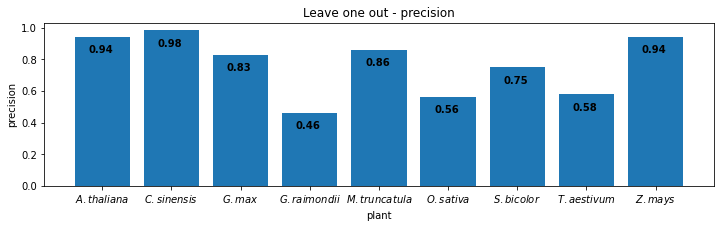

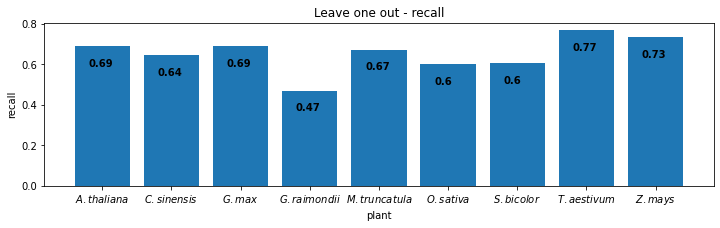

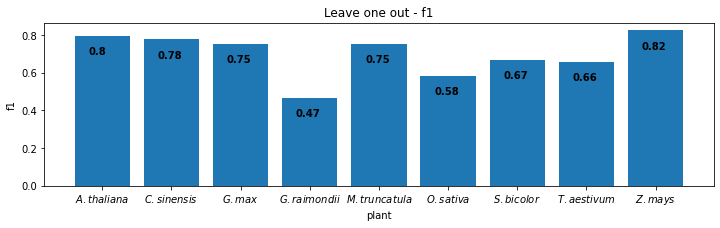

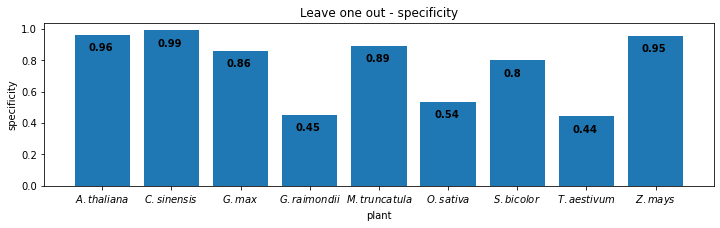

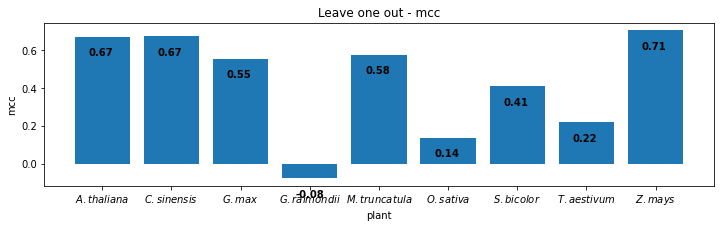

In [35]:
def plot_metrics(result, plants, prefix_name=""):
    for metric in ['accuracy', 'precision', 'recall', 'f1', "specificity", "mcc"]:
        fig, ax = plt.subplots(figsize=(12, 3))    
        y = [result[plant][metric] for plant in plants]
        ax.bar(["$\it{" + p + "}$" for p in plants], y)
        plt.title(f"Leave one out - {metric}")
        plt.xlabel("plant")
        plt.ylabel(metric)
        for i, v in enumerate(y):
            ax.text(i - 0.2 , v - 0.1, str(round(v, 2)), color='black', fontweight='bold')
        #plt.savefig(os.path.join(f'./Result/{prefix_name}_leave_one_out_{metric}.svg'), dpi=300, format='svg', bbox_inches='tight')        
        plt.show()
        
plot_metrics(result, ['A.thaliana', 'C.sinensis', 'G.max', 'G.raimondii', 'M.truncatula', 'O.sativa', 'S.bicolor', 'T.aestivum', 'Z.mays'], prefix_name="")    